# Trouble Shooting

## 1) Missaligned Spectra

A common issue is, that the spectral axis are not propelry aligned. In that case, we have to manually shift the spectrum to correct for the missalignment

In [19]:
import numpy as np
from astropy.io import fits
from reproject import reproject_interp
import matplotlib.pyplot as plt
import copy


In [22]:
#struct = np.load('./../PyStructure/Output/ngc5194_data_struct_2020_08_13.npy',allow_pickle = True).item()
struct = np.load('./../PyStructure/Output/NGC6946_data_struct_2020_08_13.npy',allow_pickle = True).item()

In [32]:
struct.keys()

dict_keys(['gal', 'ra_deg', 'dec_deg', 'dist_mpc', 'posang_deg', 'incl_deg', 'beam_as', 'rgal_as', 'rgal_kpc', 'rgal_r25', 'theta_rad', 'SPEC_VAL_12CO21', 'SPEC_VCHAN0_12CO21', 'SPEC_DELTAV_12CO21', 'SPEC_UC_12CO21', 'SPEC_COV_12CO21', 'SPEC_RES_12CO21', 'SPEC_UNIT_12CO21', 'SPEC_DESC_12CO21', 'SPEC_VAL_CII', 'SPEC_VCHAN0_CII', 'SPEC_DELTAV_CII', 'SPEC_UC_CII', 'SPEC_COV_CII', 'SPEC_RES_CII', 'SPEC_UNIT_CII', 'SPEC_DESC_CII', 'INT_VAL_12CO21', 'INT_UC_12CO21', 'INT_COV_12CO21', 'INT_RES_12CO21', 'INT_UNIT_12CO21', 'INT_DESC_12CO21', 'SPEC_VAL_SHUFF12CO21', 'SPEC_VCHAN0_SHUFF12CO21', 'SPEC_DELTAV_SHUFF12CO21', 'SPEC_UC_SHUFF12CO21', 'SPEC_COV_SHUFF12CO21', 'SPEC_RES_SHUFF12CO21', 'SPEC_UNIT_SHUFF12CO21', 'SPEC_DESC_SHUFF12CO21', 'SPEC-DELTAV_SHUFF12CO21', 'INT_VAL_CII', 'INT_UC_CII', 'INT_COV_CII', 'INT_RES_CII', 'INT_UNIT_CII', 'INT_DESC_CII', 'SPEC_VAL_SHUFFCII', 'SPEC_VCHAN0_SHUFFCII', 'SPEC_DELTAV_SHUFFCII', 'SPEC_UC_SHUFFCII', 'SPEC_COV_SHUFFCII', 'SPEC_RES_SHUFFCII', 'SPEC_UNIT_SH

In [34]:
np.arange(3)

array([0, 1, 2])

In [35]:
struct["SPEC_VAL_12CO21"][0]

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,  0.00173981, -0.01392346,
       -0.01234968,  0.01389345, -0.01254258,  0.01086739, -0.00505162,
       -0.03462849,  0.02894946,  0.02745839,  0.00232787,  0.0233261 ,
       -0.00632335,  0.00906984,  0.02097542,  0.01076959, -0.00342415,
        0.00464798,  0.01586586, -0.00795025, -0.03026711,  0.01506393,
        0.02972789,  0.00682572,  0.01718995,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

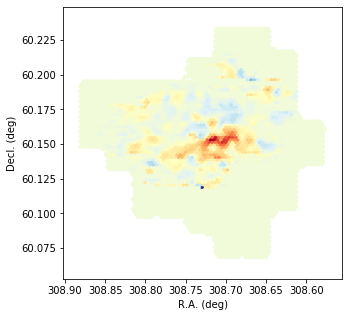

In [29]:
# get the coordinates from the structure
ra = struct["ra_deg"]
dec = struct["dec_deg"]

#get the CO21 intensity
int_co10 = struct["INT_VAL_CII"]

plt.figure(figsize=(5,5))
ax = plt.subplot(1,1,1)
ax.scatter(ra,dec,c=int_co10,marker="h",s=14, cmap="RdYlBu_r")
ax.invert_xaxis()
ax.set_xlabel("R.A. (deg)")
ax.set_ylabel("Decl. (deg)")
plt.show()

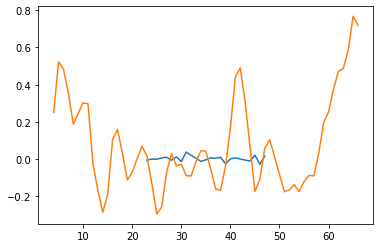

In [31]:
plt.plot(struct["SPEC_VAL_12CO21"][3096])
plt.plot(struct["SPEC_VAL_CII"][3096])

### Problem: Somehow, the CO(1-0) intensity is not correctly calculated!

In [27]:
vaxis = struct["SPEC_VCHAN0_12CO21"]+np.arange(len(struct["SPEC_VAL_12CO21"][0]))*struct["SPEC_DELTAV_12CO21"]
vaxis10 = struct["SPEC_VCHAN0_12CO10"]+np.arange(len(struct["SPEC_VAL_12CO10"][0]))*struct["SPEC_DELTAV_12CO10"]

Text(0, 0.5, 'Intensity [K]')

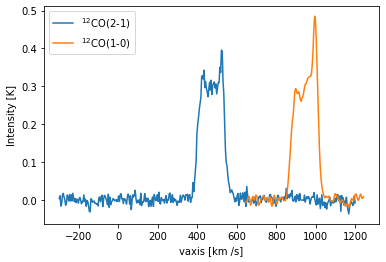

In [29]:
plt.plot(vaxis/1000, struct["SPEC_VAL_12CO21"][590], label=r"$^{12}$CO(2-1)")
plt.plot(vaxis10/1000, struct["SPEC_VAL_12CO10"][590],label=r"$^{12}$CO(1-0)")
plt.legend()
plt.xlabel("vaxis [km /s]")
plt.ylabel("Intensity [K]")

### We see that the spectra are not properly aligned. So we need to fix that!

**Download the two FITS files**

In [30]:
hdul10 = fits.open("./../PyStructure/data/ngc5194_12co10.fits")
hdul21 = fits.open("./../PyStructure/data/ngc5194_12co21.fits")

hdr_co21 = hdul21[0].header

**Do a reprojection**: Regridd the CO(1-0) spectrum onto the CO(2-1) data grid

In [31]:
co10_reproj, footprint = reproject_interp(hdul10, hdr_co21)

**Plot to make sure it now aligns**

In [18]:
vaxis=np.arange(hdr_co21["NAXIS3"])*hdr_co21["CDELT3"]+hdr_co21["CRVAL3"]

Text(0, 0.5, 'intensity [K]')

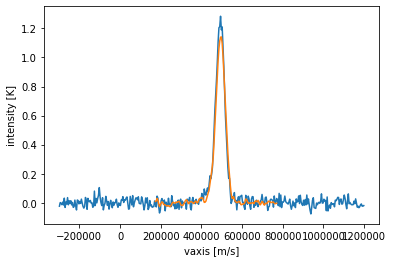

In [32]:
plt.plot(vaxis,hdul21[0].data[:,60,62])
plt.plot(vaxis,co10_reproj[:,60,62])
plt.xlabel("vaxis [m/s]")
plt.ylabel("intensity [K]")

**Save the new, regridded CO(1-0) cube (! use now the header from co(2-1)!)**

In [17]:
fits.writeto("./../PyStructure/data/ngc5194_12co10_repr.fits", data = co10_reproj, header = hdr_co21, overwrite=True)

# 2) Cube is 4 dimensional
In that case, we have to make it a 3D cube

In [ ]:
hdul = fits.open("<path to file>")
data = hdul[0].data

#usually data is a list of cubes, that's why it is 4D. If there's only 1 cube, we do:
hdul[0].data = data[0]

#assign it back to the fits file
hdul[0].data = data

#need to update the header, to tell it it is now a 3D cube
header = hdul[0].header

#now only has 3 axes
header["NAXIS"] = 3
#delete all the 4th axis info
del header["*4"]

#reasign header
hdul[0].header = header


#save the fits file
hdul.writeto("<path to file>", overwrite = True)